# Notebook to reproduce Figure 2

## Import

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
from matplotlib import colormaps
import seaborn as sns
import importlib
import functions_IDEAS
importlib.reload(functions_IDEAS)

from functions_IDEAS import compute_ID


## Functions

In [2]:
def preprocess_genes(Adata):

    sc.pp.filter_genes(Adata, min_cells=int(0.01 * len(Adata))) #filter out genes expressed in less than 1% of cells

    coding_genes = np.load('../Metadata/coding_genes.npy') #select coding genes
    gene_list = Adata.var.query('index in @coding_genes').index.values.tolist() 
    Adata = Adata[:,gene_list] 
    
    return  Adata

In [3]:
def normalize_id_replicates(rep1_a, rep2_a, rep1_b, rep2_b):
    """
    Normalize separateely the two replicates in the range [0, 1].

    Returns:
        Tuple of normalized DataFrames: (norm_rep1_a, norm_rep2_a, norm_rep1_b, norm_rep2_b)
    """
    
    # Flatten all values for each group
    all_values_a = pd.concat([rep1_a, rep2_a]).values.flatten()
    all_values_b = pd.concat([rep1_b, rep2_b]).values.flatten()

    # Get min and range for each group
    min_a = np.min(all_values_a)
    range_a = np.max(all_values_a) - min_a

    min_b = np.min(all_values_b)
    range_b = np.max(all_values_b) - min_b

    # Normalize
    norm_rep1_a = (rep1_a - min_a) / range_a
    norm_rep2_a = (rep2_a - min_a) / range_a

    norm_rep1_b = (rep1_b - min_b) / range_b
    norm_rep2_b = (rep2_b - min_b) / range_b

    return norm_rep1_a, norm_rep2_a, norm_rep1_b, norm_rep2_b

In [4]:
def return_df_clusters(Adata):

    sorted_days = sorted(np.unique(Adata.obs.day), key=sort_days)
    sorted_clusters = sorted(Adata.obs.cluster.unique())

    #days in different clusters
    df_cluster = pd.DataFrame(columns=sorted_days, index=sorted_clusters)

    for c in sorted_clusters:
        for d in sorted_days:
            df_cluster.loc[c,d]=len(Adata[(Adata.obs.day == d)&(Adata.obs.cluster == c)])
            

    df_cluster = df_cluster.div(df_cluster.sum(axis=1), axis=0)

    return df_cluster


In [5]:
def sort_days(item):
    if item == 'mESCs':
        return (float('inf'), item)
    
    return (int(item), item)

## Figure 2

Load datasets as AnnData objects:

In [12]:
adata_fbs=sc.read('../Datasets/FBS_IDEAS.h5ad')
adata_a2s=sc.read('../Datasets/A2S_IDEAS.h5ad')

In [14]:
adata_fbs

AnnData object with n_obs × n_vars = 3435 × 24421
    obs: 'medium', 'day', 'replicate', 'cell_type', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'cluster', 'pluripotency', 'naive_pluripotency', 'cluster_pluripotency', 'cluster_naive_pluripotency', 'dpt_pseudotime'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'day_colors', 'hvg', 'log1p'
    obsm: 'X_diffmap', 'X_umap'

In [18]:
df = adata_a2s.obs.copy()
df_umap = pd.DataFrame(adata_a2s.obsm['X_umap'], index=adata_a2s.obs_names, columns=['UMAP1', 'UMAP2'])  
df_full = pd.concat([df, df_umap], axis=1)

df_full.to_csv("../Metadata/Metadata_A2S_fig2.csv")

Preprocess genes by filtering out genes expressed in less than 1% of cells and protein coding:

In [7]:
adata_fbs = preprocess_genes(adata_fbs)
adata_a2s = preprocess_genes(adata_a2s)

Calculate the minimum number of cell counts for both experiments:

In [8]:
# A2S
_, counts_a2s_rep1 = np.unique(adata_a2s[adata_a2s.obs.replicate == '1'].obs.cluster, return_counts=True)
_, counts_a2s_rep2 = np.unique(adata_a2s[adata_a2s.obs.replicate == '2'].obs.cluster, return_counts=True)
min_count_a2s = min(counts_a2s_rep1.min(), counts_a2s_rep2.min())

# FBS
_, counts_fbs_rep1 = np.unique(adata_fbs[adata_fbs.obs.replicate == '1'].obs.cluster, return_counts=True)
_, counts_fbs_rep2 = np.unique(adata_fbs[adata_fbs.obs.replicate == '2'].obs.cluster, return_counts=True)
min_count_fbs = min(counts_fbs_rep1.min(), counts_fbs_rep2.min())

print(f"Minimum cluster size in A2S (across replicates): {min_count_a2s}")
print(f"Minimum cluster size in FBS (across replicates): {min_count_fbs}")



Minimum cluster size in A2S (across replicates): 60
Minimum cluster size in FBS (across replicates): 144


Calculate the intrinsic dimension via the TWO-Nearest-Neighbors (2nn) method. Use the minimum cluster size values to set the sample size. 

In [9]:
sample_sizeF = 140
sample_sizeA = 60
num_samples = 200

id_fbs_rep1 = compute_ID(adata_fbs[adata_fbs.obs.replicate=='1'], group = 'cluster', method='2nn', sample_size=sample_sizeF, n_samples = num_samples, full_output = True)
id_fbs_rep2 = compute_ID(adata_fbs[adata_fbs.obs.replicate=='2'], group = 'cluster', method='2nn', sample_size=sample_sizeF, n_samples = num_samples, full_output = True)

id_a2s_rep1 = compute_ID(adata_a2s[adata_a2s.obs.replicate=='1'], group = 'cluster', method='2nn', sample_size=sample_sizeA, n_samples = num_samples, full_output = True)
id_a2s_rep2 = compute_ID(adata_a2s[adata_a2s.obs.replicate=='2'], group = 'cluster', method='2nn', sample_size=sample_sizeA, n_samples = num_samples, full_output = True)

Computing Intrinsic Dimension:   0%|          | 0/5 [00:00<?, ?it/s]

Computing ID for cluster 1:


Computing Intrinsic Dimension:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

Computing ID for cluster 2:


Computing Intrinsic Dimension:  40%|████      | 2/5 [00:06<00:09,  3.28s/it]

Computing ID for cluster 3:


Computing Intrinsic Dimension:  60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

Computing ID for cluster 4:


Computing Intrinsic Dimension:  80%|████████  | 4/5 [00:12<00:03,  3.06s/it]

Computing ID for cluster 5:


Computing Intrinsic Dimension:   0%|          | 0/5 [00:00<?, ?it/s]

Computing ID for cluster 1:


Computing Intrinsic Dimension:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

Computing ID for cluster 2:


Computing Intrinsic Dimension:  40%|████      | 2/5 [00:05<00:08,  2.89s/it]

Computing ID for cluster 3:


Computing Intrinsic Dimension:  60%|██████    | 3/5 [00:08<00:05,  2.89s/it]

Computing ID for cluster 4:


Computing Intrinsic Dimension:  80%|████████  | 4/5 [00:11<00:02,  2.90s/it]

Computing ID for cluster 5:


Computing Intrinsic Dimension:   0%|          | 0/6 [00:00<?, ?it/s]

Computing ID for cluster 1:


Computing Intrinsic Dimension:  17%|█▋        | 1/6 [00:01<00:05,  1.10s/it]

Computing ID for cluster 2:


Computing Intrinsic Dimension:  33%|███▎      | 2/6 [00:02<00:04,  1.10s/it]

Computing ID for cluster 3:


Computing Intrinsic Dimension:  50%|█████     | 3/6 [00:03<00:03,  1.16s/it]

Computing ID for cluster 4:


Computing Intrinsic Dimension:  67%|██████▋   | 4/6 [00:04<00:02,  1.17s/it]

Computing ID for cluster 5:


Computing Intrinsic Dimension:  83%|████████▎ | 5/6 [00:05<00:01,  1.13s/it]

Computing ID for cluster 6:


Computing Intrinsic Dimension:   0%|          | 0/6 [00:00<?, ?it/s]

Computing ID for cluster 1:


Computing Intrinsic Dimension:  17%|█▋        | 1/6 [00:01<00:05,  1.19s/it]

Computing ID for cluster 2:


Computing Intrinsic Dimension:  33%|███▎      | 2/6 [00:02<00:04,  1.11s/it]

Computing ID for cluster 3:


Computing Intrinsic Dimension:  50%|█████     | 3/6 [00:03<00:03,  1.10s/it]

Computing ID for cluster 4:


Computing Intrinsic Dimension:  67%|██████▋   | 4/6 [00:04<00:02,  1.11s/it]

Computing ID for cluster 5:


Computing Intrinsic Dimension:  83%|████████▎ | 5/6 [00:05<00:01,  1.09s/it]

Computing ID for cluster 6:


Computing Intrinsic Dimension: 100%|██████████| 6/6 [00:06<00:00,  1.09s/it]


Normalize plot in range [0,1]:

In [10]:
id_fbs_rep1, id_fbs_rep2, id_a2s_rep1, id_a2s_rep2 = normalize_id_replicates( id_fbs_rep1, id_fbs_rep2, id_a2s_rep1, id_a2s_rep2)

Plot Figure 2:

/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_55988/2457171147.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


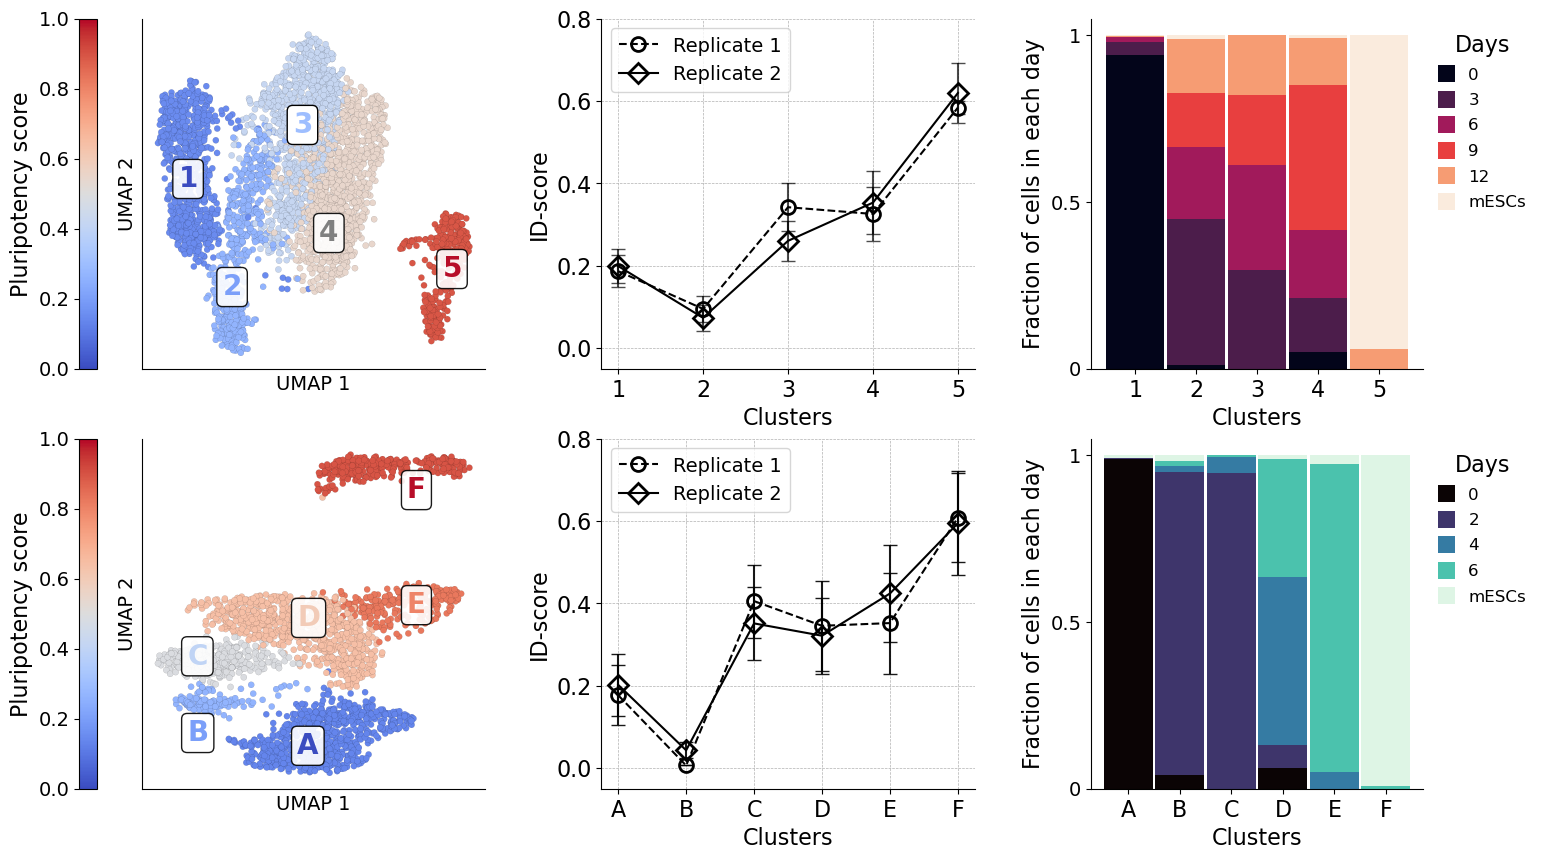

In [11]:
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=[1.1, 0.9, 0.8], height_ratios=[1, 1], wspace=0.3, hspace=0.2)
axes = np.empty((2, 3), dtype=object)
for i in range(2):
    for j in range(3):
        axes[i, j] = fig.add_subplot(gs[i, j])

# UMAP FBS
cmap = 'coolwarm'
vmin_fbs = 0
vmax_fbs = 1
norm_fbs = Normalize(vmin=vmin_fbs, vmax=vmax_fbs)
sm_fbs = ScalarMappable(cmap=cmap, norm=norm_fbs)
sm_fbs.set_array([])

umap_c_fbs = adata_fbs.obsm['X_umap']
axes[0][0].scatter(umap_c_fbs[:,0], umap_c_fbs[:,1], s=20, alpha=1., cmap=cmap, norm=norm_fbs,
                   c=adata_fbs.obs.cluster_pluripotency.values, edgecolors='black', linewidths=0.05)
axes[0][0].xaxis.set_ticks([])
axes[0][0].yaxis.set_ticks([])
axes[0][0].set_xlabel('UMAP 1', fontsize=14)
axes[0][0].set_ylabel('UMAP 2', fontsize=14)
axes[0][0].set_rasterized(True)

colors = plt.get_cmap('coolwarm')
axes[0][0].text(3.,6.5,'1', fontweight='bold', fontsize=20, color=colors(0), bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[0][0].text(5.5,3.5,'2', fontweight='bold', fontsize=20, color=colors(0.2), bbox = dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[0][0].text(9.5,8,'3', fontweight='bold', fontsize=20, color=colors(0.3), bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=1))
axes[0][0].text(11,5,'4', fontweight='bold', fontsize=20, color='gray', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[0][0].text(18,4,'5', fontweight='bold', fontsize=20, color=colors(0.99), bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))

cbar = fig.colorbar(sm_fbs, ax=axes[0][0], pad=0.1, location='left')
cbar.set_label('Pluripotency score', fontsize=16)
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
sns.despine(ax=axes[0][0])

# UMAP A2S
vmin_a2s = 0
vmax_a2s = 1
norm_a2s = Normalize(vmin=vmin_a2s, vmax=vmax_a2s)
sm_a2s = ScalarMappable(cmap=cmap, norm=norm_a2s)
sm_a2s.set_array([])

umap_c_a2s = adata_a2s.obsm['X_umap']
axes[1][0].scatter(umap_c_a2s[:,0], umap_c_a2s[:,1], s=20, alpha=1., cmap=cmap, norm=norm_a2s,
                   c=adata_a2s.obs.cluster_pluripotency.values, edgecolors='black', linewidths=0.05)
axes[1][0].xaxis.set_ticks([])
axes[1][0].yaxis.set_ticks([])
axes[1][0].set_xlabel('UMAP 1', fontsize=14)
axes[1][0].set_ylabel('UMAP 2', fontsize=14)
axes[1][0].set_rasterized(True)

axes[1][0].text(10,-10,'A', fontweight='bold', fontsize=20, color=colors(0), bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[1][0].text(7,-9,'B', fontweight='bold', fontsize=20, color=colors(0.2), bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[1][0].text(7,-3,'C', fontweight='bold', fontsize=20, color=colors(0.4), bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[1][0].text(10,0,'D', fontweight='bold', fontsize=20, color=colors(0.6), bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[1][0].text(13,1,'E', fontweight='bold', fontsize=20, color=colors(0.8), bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[1][0].text(13,10,'F', fontweight='bold', fontsize=20, color=colors(0.99), bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))

cbar = fig.colorbar(sm_a2s, ax=axes[1][0], pad=0.1, location='left')
cbar.set_label('Pluripotency score', fontsize=16)
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.set_major_formatter(ScalarFormatter())
sns.despine(ax=axes[1][0])

# ID FBS
col1 = id_fbs_rep1.columns
mean1 = np.mean(id_fbs_rep1, axis = 0)
std1 = np.std(id_fbs_rep1, axis = 0)
col2 = id_fbs_rep2.columns
mean2 = np.mean(id_fbs_rep2, axis = 0)
std2 = np.std(id_fbs_rep2, axis = 0)

axes[0][1].plot(col1, mean1, marker='o', markersize=10, markerfacecolor='none', markeredgewidth=2, color='black', linestyle='--', label='Replicate 1')
axes[0][1].errorbar(col1, mean1, yerr=std1, fmt=' ', alpha=0.7, color='black', capsize=5)
axes[0][1].plot(col2, mean2, marker='D', markersize=10, markerfacecolor='none', markeredgewidth=2, color='black', label='Replicate 2')
axes[0][1].errorbar(col2, mean2, yerr=std2, fmt=' ', alpha=0.7, color='black', capsize=5)
axes[0][1].set_xlabel('Clusters', fontsize=16)
axes[0][1].set_xticks(axes[0][1].get_xticks())
axes[0][1].set_xticklabels(['1','2','3','4','5'])
axes[0][1].set_ylabel('ID-score', fontsize=16)
axes[0][1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0][1].tick_params(axis='both', which='major', labelsize=16)
axes[0][1].legend(fontsize=14 , loc='upper left')
axes[0][1].set_ylim([-0.05, 0.8])
sns.despine(ax=axes[0][1])

# ID A2S
col1_A = id_a2s_rep1.columns
mean1_A = np.mean(id_a2s_rep1, axis = 0)
std1_A = np.std(id_a2s_rep1, axis = 0)
col2_A = id_a2s_rep2.columns
mean2_A = np.mean(id_a2s_rep2, axis = 0)
std2_A = np.std(id_a2s_rep2, axis = 0)

axes[1][1].plot(col1_A, mean1_A, marker='o', markersize=10, markerfacecolor='none', markeredgewidth=2, color='black', linestyle='--', label='Replicate 1')
axes[1][1].errorbar(col1_A, mean1_A, yerr=std1_A, fmt=' ', alpha=0.9, color='black', capsize=5)
axes[1][1].plot(col2_A, mean2_A, marker='D', markersize=10, markerfacecolor='none', markeredgewidth=2, color='black', label='Replicate 2')
axes[1][1].errorbar(col2_A, mean2_A, yerr=std2_A, fmt=' ', alpha=0.9, color='black', capsize=5)
axes[1][1].set_xlabel('Clusters', fontsize=16)
axes[1][1].set_xticks(axes[1][1].get_xticks())
axes[1][1].set_xticklabels(['A','B','C','D','E','F'])
axes[1][1].set_ylabel('ID-score', fontsize=16)
axes[1][1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1][1].tick_params(axis='both', which='major', labelsize=16)
axes[1][1].legend(fontsize=14 , loc='upper left')
axes[1][1].set_ylim([-0.05, 0.8])
sns.despine(ax=axes[1][1])

# Stack bar FBS
df_cluster = return_df_clusters(adata_fbs)
df_cluster.plot(kind='bar', stacked=True, colormap='rocket', width=0.95, ax=axes[0][2])
axes[0][2].set_xlabel('Clusters', fontsize=16)
axes[0][2].set_xticklabels(['1','2','3','4','5'], fontsize=16)
axes[0][2].tick_params(axis='x', labelrotation=0)
axes[0][2].set_ylabel('Fraction of cells in each day', fontsize=16)
axes[0][2].set_yticks([0, 0.5, 1])
axes[0][2].set_yticklabels(['0', '0.5', '1'], fontsize=14)
legend = axes[0][2].legend(title='Days', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=16, handlelength=1, handleheight=1.2)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_linewidth(0.0)
frame.set_boxstyle('square', pad=0)
sns.despine(ax=axes[0][2])

# Stack bar A2S
df_cluster_A = return_df_clusters(adata_a2s)
df_cluster_A.plot(kind='bar', stacked=True, colormap='mako', width=0.95, ax=axes[1][2])
axes[1][2].set_xlabel('Clusters', fontsize=16)
axes[1][2].set_xticklabels(['A','B','C','D','E','F'], fontsize=16)
axes[1][2].tick_params(axis='x', labelrotation=0)
axes[1][2].set_ylabel('Fraction of cells in each day', fontsize=16)
axes[1][2].set_yticks([0, 0.5, 1])
axes[1][2].set_yticklabels(['0', '0.5', '1'], fontsize=14)
legend = axes[1][2].legend(title='Days', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=16, handlelength=1, handleheight=1.2)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_linewidth(0.0)
frame.set_boxstyle('square', pad=0)
sns.despine(ax=axes[1][2])

# Fine
plt.tight_layout()
plt.show()
